### 분석에 필요한 패키지 Import

In [1]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
!pip install xgboost lightgbm catboost scikit-learn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [5]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [6]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [7]:
target = 'LeaveOrNot'

In [8]:
X = df.drop(columns=target) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [10]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [13]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [14]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [17]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3, 
    random_state=SEED
)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3257, 8)
(3257,)
(1396, 8)
(1396,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [19]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [20]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [21]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7177650429799427
Report :
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       920
           1       0.64      0.40      0.49       476

    accuracy                           0.72      1396
   macro avg       0.69      0.64      0.65      1396
weighted avg       0.70      0.72      0.70      1396



#### 2. 의사결정나무

In [22]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
y_tree_pred = tree.predict(X_test)

In [24]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8302292263610315
Report :
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       920
           1       0.78      0.70      0.74       476

    accuracy                           0.83      1396
   macro avg       0.82      0.80      0.81      1396
weighted avg       0.83      0.83      0.83      1396



#### 3. SVM

In [25]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [26]:
y_svm_pred = svm.predict(X_test)

In [27]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8474212034383954
Report :
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       920
           1       0.90      0.62      0.73       476

    accuracy                           0.85      1396
   macro avg       0.87      0.79      0.81      1396
weighted avg       0.86      0.85      0.84      1396



#### 4. kNN

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [29]:
y_knn_pred = knn.predict(X_test)

In [30]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8194842406876791
Report :
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       920
           1       0.80      0.63      0.70       476

    accuracy                           0.82      1396
   macro avg       0.81      0.77      0.79      1396
weighted avg       0.82      0.82      0.81      1396



#### 네 가지 단일 모델의 결과 비교

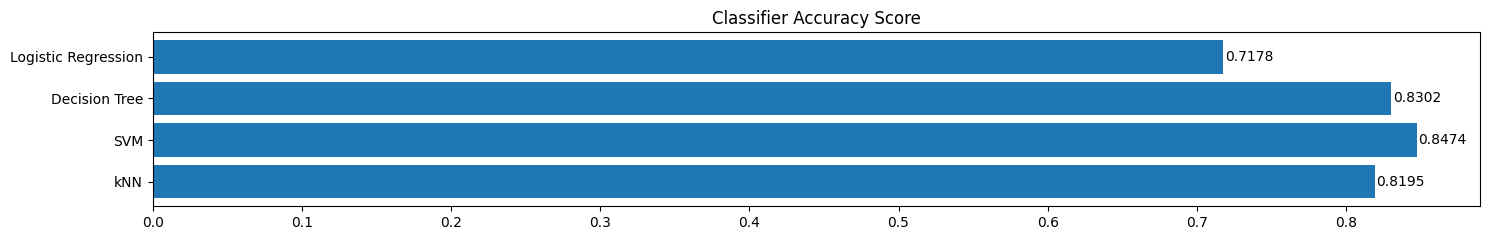

In [31]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [32]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [33]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8489


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [34]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8496


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [35]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8181


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [36]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8582


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [37]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8639


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [38]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8567


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [39]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8610


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [40]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=lr, # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8532


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

In [41]:
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [42]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [43]:
df['City'].unique()

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [44]:
df['Education'].unique()

array(['Bachelors', 'Masters', 'PHD'], dtype=object)

1. 다중공선성 확인하여 칼럼 정리하기!

In [141]:
target = 'LeaveOrNot'
X = df.drop(columns=target) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [142]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif = pd.DataFrame()
df_vif['VIF'] = np.round([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 2)
df_vif['Feature'] = X.columns
df_vif = df_vif.sort_values(by='VIF', ascending=False)

In [143]:
X = X.drop(columns=['JoiningYear'])

In [144]:
X = X.drop(columns=['PaymentTier'])

In [145]:
X = X.drop(columns=['Age'])

In [146]:
df_vif

,VIF,Feature
1,75.98,JoiningYear
4,38.87,Age
3,27.79,PaymentTier
7,4.56,ExperienceInCurrentDomain
5,2.66,Gender
2,2.13,City
0,1.31,Education
6,1.12,EverBenched


In [147]:
import statsmodels.api as sm

# 회귀 모형
multi_linear_model = sm.OLS(y, X)
result_model_1 = multi_linear_model.fit()

# 결과
result_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             LeaveOrNot   R-squared (uncentered):                   0.345
Model:                            OLS   Adj. R-squared (uncentered):              0.345
Method:                 Least Squares   F-statistic:                              490.5
Date:                Tue, 06 May 2025   Prob (F-statistic):                        0.00
Time:                        16:22:40   Log-Likelihood:                         -3132.9
No. Observations:                4653   AIC:                                      6276.
Df Residuals:                    4648   BIC:                                      6308.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Education                     0.0902      0.013      6.727      0.000       0.064       0.116
City                          0.1585      0.008     20.433      0.000       0.143       0.174
Gender                       -0.0455      0.012     -3.647      0.000      -0.070      -0.021
EverBenched                   0.1911      0.023      8.389      0.000       0.146       0.236
ExperienceInCurrentDomain     0.0521      0.003     15.878      0.000       0.046       0.059
==============================================================================
Omnibus:                     1993.294   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              466.030
Skew:                           0.550   Prob(JB):                    6.35e-102
Kurtosis:                       1.908   Cond. No.                         11.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'JoiningYear', 'PaymentTier', 'Age'를 제거하니 VIF가 모두 3이하로 내려갔습니당


대충 직감으로 보면 아무래도 다들 연차가 쌓이는 거랑 관련있어서 그런 듯?


아무튼 계속 진행해보겠습니다

In [148]:
# standardscaler를 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [149]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3, 
    random_state=SEED
)

In [150]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7313753581661891
Report :
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       920
           1       0.68      0.41      0.51       476

    accuracy                           0.73      1396
   macro avg       0.71      0.65      0.66      1396
weighted avg       0.72      0.73      0.71      1396



과제대로: 0.7177650429799427

내 방식: 0.7313753581661891

-> 일단 전처리 덕분에 로지스틱 회귀 단일모델 성능이 올라가긴함!

In [151]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

y_tree_pred = tree.predict(X_test)

tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.7671919770773639
Report :
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       920
           1       0.81      0.42      0.55       476

    accuracy                           0.77      1396
   macro avg       0.78      0.68      0.70      1396
weighted avg       0.77      0.77      0.74      1396



과제대로: 0.8302292263610315

내 방식: 0.7671919770773639

-> 성능이 내려감 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ

In [63]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

y_svm_pred = svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.7736389684813754
Report :
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       920
           1       0.81      0.44      0.57       476

    accuracy                           0.77      1396
   macro avg       0.79      0.69      0.71      1396
weighted avg       0.78      0.77      0.75      1396



과제대로: 0.8474212034383954

내 방식: 0.7736389684813754

-> 이거도 성능이 내려감... 다중공선성 제거가 로지스틱 회귀에 한해서만 효과 개선이 있는 듯?

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_knn_pred = knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.7349570200573066
Report :
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       920
           1       0.63      0.53      0.58       476

    accuracy                           0.73      1396
   macro avg       0.70      0.69      0.69      1396
weighted avg       0.73      0.73      0.73      1396



과제대로: 0.8194842406876791

내 방식: 0.7349570200573066

-> 망한 smell이 점점 나지만 그냥 가볼게요 ^^

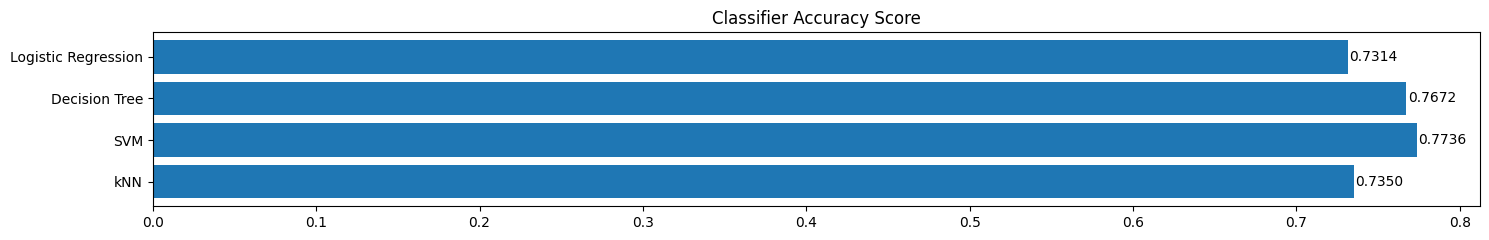

In [65]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

SVM + Decision Tree + Logistic Regression 모델 조합으로 해보겠습니다

앙상블 적용하기

In [75]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('svc', SVC(random_state=SEED))
]

hard voting 적용하기

In [76]:
# hard voting
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.7701


bagging (random forest) 적용하기

In [78]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.7665


AdaBoost 적용하기

In [79]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.7486


GBM 적용하기

In [82]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.7758


In [83]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.7708


In [84]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.7758


In [85]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.7686


GBM이랑 LightGBM이 그나마 정확도가 높은데 이 둘의 하이퍼 파라미터 튜닝을 해보겠습니다.

#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [104]:
# 모델 생성
gbm = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.7751


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [152]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(num_leaves=31, max_depth=-1, learning_rate=0.01, n_estimators=100, objective='binary', random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):f}")

LightGBM Accuracy: 0.777221


전처리 했을 때 나의 최선:

LightGBM Accuracy: 0.777221

In [ ]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

target = 'LeaveOrNot'
X = df.drop(columns=target) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))


# standardscaler를 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3, 
    random_state=SEED
)

In [139]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(num_leaves=31, max_depth=-1, learning_rate=0.01, n_estimators=700, objective='binary', random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):f}")

LightGBM Accuracy: 0.862464


전처리 따로 안하고 하이퍼파라미터 튜닝만 했을 때 나의 최선:

LightGBM Accuracy: 0.862464